# Flocks, Herds, and Traffic Jams

Code examples from [Think Complexity, 2nd edition](http://greenteapress.com/wp/complexity2), Chapter 10

Copyright 2016 Allen Downey, [MIT License](http://opensource.org/licenses/MIT)

In [1]:
from __future__ import print_function, division

%matplotlib inline
%precision 3

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

import thinkplot
from thinkstats2 import RandomSeed

from Cell2D import Cell2DViewer

from matplotlib import rc
rc('animation', html='html5')

In [2]:
class Driver:
    
    def __init__(self, loc, speed=4):
        """Initialize the attributes.
        
        loc: position on track, in miles
        speed: speed in miles per hour
        """
        self.start = loc
        self.loc = loc
        self.speed = speed
        
    def choose_acceleration(self, d):
        return 1
        
    def set_odometer(self):
        self.start = self.loc
        
    def read_odometer(self):
        return self.loc - self.start

In [3]:
class Highway:
    
    max_acc = 1
    min_acc = -10
    speed_limit = 40
    
    def __init__(self, n=10, length=1000, eps=0, constructor=Driver):
        """Initializes the attributes.
        
        n: number of drivers
        length: length of the track
        eps: variability in speed
        constructor: function used to instantiate drivers
        """
        self.length = length
        self.eps = eps
        self.crashes = 0

        # create the drivers
        locs = np.linspace(0, length, n, endpoint=False)
        self.drivers = [constructor(loc) for loc in locs]
        
        # and link them up
        for i in range(n):
            j = (i+1) % n
            self.drivers[i].next = self.drivers[j]
            
    def step(self):
        """Performs one time step."""
        for driver in self.drivers:
            self.move(driver)
            
    def move(self, driver):
        """Updates `driver`.
        
        driver: Driver object
        """
        # get the distance to the next driver
        d = self.distance(driver)

        # let the driver choose acceleration
        acc = driver.choose_acceleration(d)
        acc = min(acc, self.max_acc)
        acc = max(acc, self.min_acc)
        speed = driver.speed + acc
            
        # add random noise to speed
        speed *= np.random.uniform(1-self.eps, 1+self.eps)
        
        # keep it nonnegative and under the speed limit
        speed = max(speed, 0)
        speed = min(speed, self.speed_limit)
        
        # if current speed would collide with next driver, stop
        if speed > d:
            speed = 0
            self.crashes += 1
            
        # update speed and loc
        driver.speed = speed
        driver.loc += speed
            
    def distance(self, driver):
        """Distance from `driver` to next driver.
        
        driver: Driver object
        """
        d = driver.next.loc - driver.loc
        # fix wraparound
        if d < 0:
            d += self.length
        print(d)
        return d
    
    def set_odometers(self):
        return [driver.set_odometer()
                for driver in self.drivers] 
    
    def read_odometers(self):
        return np.mean([driver.read_odometer()
                        for driver in self.drivers])

In [4]:
class HighwayViewer(Cell2DViewer):
    """Generates visualization and animation of SugarScape."""
    
    def draw(self, grid=False):
        """Draws the array and any other elements.
        
        grid: boolean, whether to draw grid lines
        """
        self.draw_drivers()
        
        plt.axis('off')
        plt.axis('equal')
        plt.xlim([-1.05, 1.05])
        plt.ylim([-1.05, 1.05])

    def draw_drivers(self):
        """Plots the drivers.
        """
        drivers = self.viewee.drivers
        xs, ys = self.get_coords(drivers)
        self.points = plt.plot(xs, ys, '.', color='blue', markersize=20)[0]
        
        stopped = [driver for driver in self.viewee.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped)
        xs *= 0.9
        ys *= 0.9
        self.stopped = plt.plot(xs, ys, 'x', color='red')[0]
        
    def animate_func(self, i):
        """Draws one frame of the animation."""
        if i > 0:
            self.step()
        drivers = self.viewee.drivers
        xs, ys = self.get_coords(drivers)
        self.points.set_data(np.array([xs, ys]))
        
        stopped = [driver for driver in self.viewee.drivers 
                  if driver.speed==0]
        xs, ys = self.get_coords(stopped)
        self.stopped.set_data(np.array([xs, ys]) * 0.9)
        return self.points,
    
    def get_coords(self, drivers):
        """Gets the coordinates of the drivers.
        
        Transforms from (row, col) to (x, y).
        
        returns: tuple of sequences, (xs, ys)
        """
        scale = 2 * np.pi / self.viewee.length
        
        locs = np.array([driver.loc for driver in drivers])
        xs = np.cos(locs * scale)
        ys = np.sin(locs * scale)
        return xs, ys

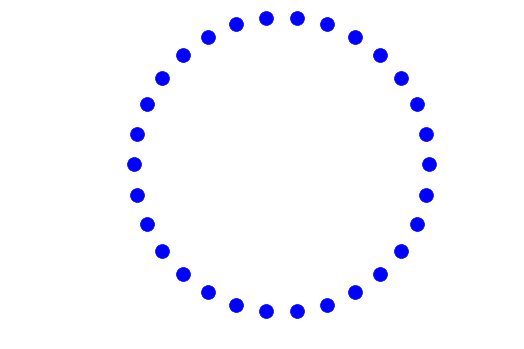

In [10]:
highway = Highway(30, eps=0.02)
viewer = HighwayViewer(highway)
anim = viewer.animate(frames=600, interval=200)

In [6]:
anim

KeyError: u'ffmpeg'

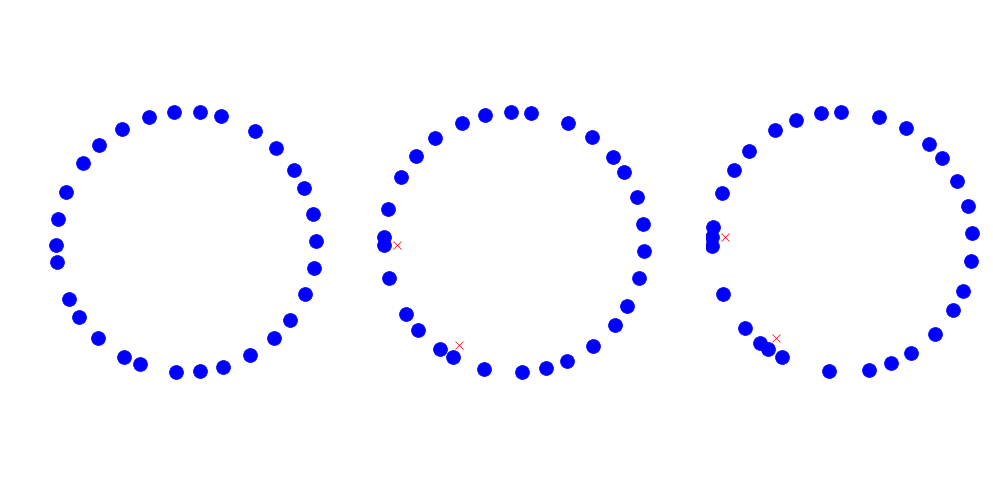

In [7]:
RandomSeed(22)

highway = Highway(30, eps=0.02)
viewer = HighwayViewer(highway)

thinkplot.preplot(cols=3)
for i in range(16):
    highway.step()
viewer.draw()

thinkplot.subplot(2)
for i in range(1):
    highway.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(1):
    highway.step()
viewer.draw()

plt.savefig('chap10-1.pdf')

In [8]:
def run_simulation(eps, constructor=Driver, iters=100):
    res = []
    for n in range(5, 100, 5):
        highway = Highway(n, eps=eps, constructor=constructor)
        for i in range(iters):
            highway.step()

        highway.set_odometers()
        for i in range(iters):
            highway.step()

        res.append((n, highway.read_odometers() / iters))
    
    return np.transpose(res)

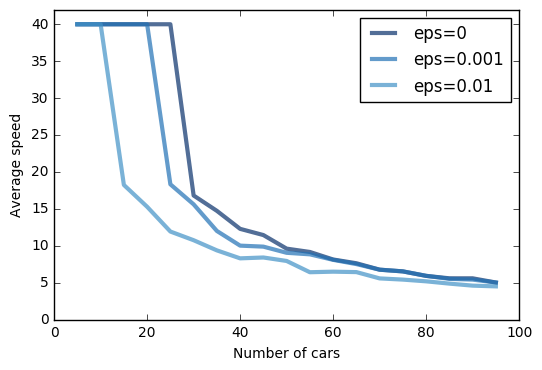

In [9]:
RandomSeed(20)

for eps in [0.0, 0.001, 0.01]:
    xs, ys = run_simulation(eps)
    thinkplot.plot(xs, ys, label='eps=%g' % eps)
    
thinkplot.config(xlabel='Number of cars',
                 ylabel='Average speed',
                 xlim=[0, 100], ylim=[0, 42])

plt.savefig('chap10-2.pdf')

**Exercise:** In the traffic jam simulation, define a class, `BetterDriver`,
that inherits from `Driver` and overrides `choose_acceleration`.
See if you can define driving rules that do better than the basic
implementation in `Driver`.  You might try to achieve higher
average speed, or a lower number of collisions.

In [86]:
class BetterDriver(Driver):
    
    def choose_acceleration(self, d, threshold=30):
        if d < threshold:
            return 0
        else:
            return 1

In [87]:
class BetterBetterDriver(Driver):
    
    def choose_acceleration(self, d, threshold=30):
        if d < threshold:
            return -5
        else:
            return 1

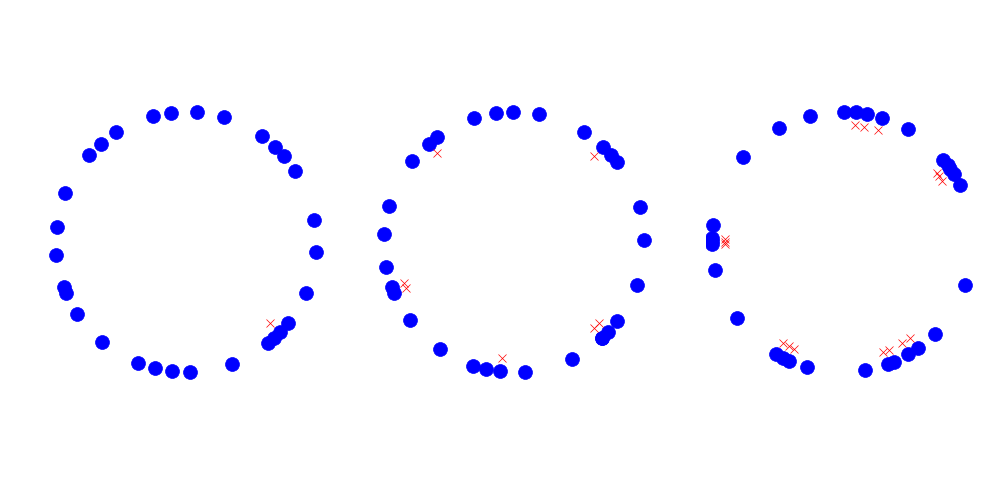

In [92]:
H = Highway(30, eps=0.02, constructor=BetterBetterDriver)

viewer = HighwayViewer(H)

thinkplot.preplot(cols=3)
for i in range(16):
    H.step()
viewer.draw()

thinkplot.subplot(2)
for i in range(1):
    H.step()
viewer.draw()

thinkplot.subplot(3)
for i in range(30):
    H.step()
viewer.draw()

#Due to some computer trouble, I haven't gotten animations to work, but I plotted for 30 time steps.

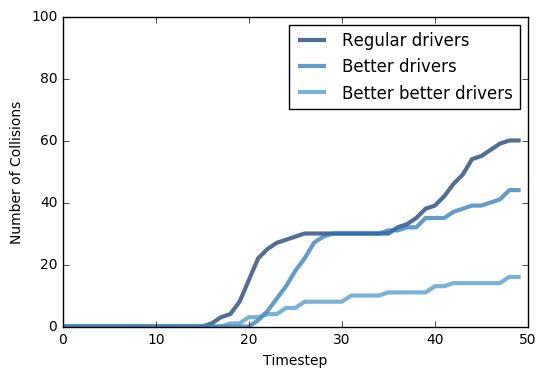

In [91]:
r = range(50)
collisions = []
betterCollisions = []
bBetterCollisions = []

HBBetter = Highway(30, eps=0.02, constructor=BetterBetterDriver)
HBetter = Highway(30, eps=0.02, constructor=BetterDriver)
H = Highway(30, eps=0.02)

for i in r:
    HBBetter.step()
    HBetter.step()
    H.step()
    collisions.append(H.crashes)
    betterCollisions.append(HBetter.crashes)
    bBetterCollisions.append(HBBetter.crashes)

thinkplot.plot(r, collisions, label="Regular drivers")
thinkplot.plot(r, betterCollisions, label="Better drivers")
thinkplot.plot(r, bBetterCollisions, label="Better better drivers")


thinkplot.config(xlabel='Timestep',
                 ylabel='Number of Collisions',
                ylim=[0, 100])

#The graph shows three different drivers -- One who accelerates regardless of where other drivers are, one who stops accelerating
#but doesn't slow down either when other cars are near, and one that slows down. As the graph shows, the number of crashes can be
#decreased significantly just by slowing down.